In [ ]:
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
%matplotlib inline
from datetime import datetime
#rcParams['figure.figsize'] = 10,6

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 25)

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['patch.force_edgecolor'] = True
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import sklearn
from sklearn.preprocessing import OneHotEncoder

from datetime import datetime
rcParams['figure.figsize'] = 10,6
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

from google.colab import drive
drive.mount('/content/drive', force_remount=True)
DATADIR = '/content/drive/My Drive/FDA Buddies/'

Mounted at /content/drive


In [ ]:
fda = pd.read_csv(DATADIR + 'CAERS_ProductBased.csv')
fda.head()

,DATE_FDA_FIRST_RECEIVED_REPORT,REPORT_ID,DATE_EVENT,PRODUCT_TYPE,PRODUCT,PRODUCT_CODE,DESCRIPTION,PATIENT_AGE,AGE_UNITS,SEX,CASE_MEDDRA_PREFERRED_TERMS,CASE_OUTCOME,Unnamed: 12
0,6/30/2023,2023-CFS-006722,6/27/2023,SUSPECT,AIRLINE FOOD SERVED BY UNITED AIRLINES,37,Mult Food Dinner/Grav/Sauce/Special,45.0,year(s),Male,"Diarrhoea, Food poisoning, Pyrexia, Tremor, Vo...",Other Serious or Important Medical Event,NaN
1,6/30/2023,2023-CFS-006720,NaN,SUSPECT,ONE A DAY WOMEN'S,54,Vit/Min/Prot/Unconv Diet(Human/Animal),NaN,NaN,NaN,Suicidal ideation,Other Serious Outcome,NaN
2,6/30/2023,2023-CFS-006718,6/22/2023,SUSPECT,RITUAL ESSENTIAL PRENATAL MULTIVITAMIN,54,Vit/Min/Prot/Unconv Diet(Human/Animal),NaN,NaN,Female,Chest pain,"Hospitalization, Other Serious or Important Me...",NaN
3,6/30/2023,2023-CFS-006717,NaN,SUSPECT,METAMUCIL,54,Vit/Min/Prot/Unconv Diet(Human/Animal),46.0,year(s),Female,"Pain, Vomiting","Hospitalization, Other Serious or Important Me...",NaN
4,6/30/2023,2023-CFS-006714,NaN,SUSPECT,NATURE'S BOUNTY CALCIUM 1200MG PLUS 25MCG (100...,54,Vit/Min/Prot/Unconv Diet(Human/Animal),NaN,NaN,NaN,"Nephrolithiasis, Renal injury","Hospitalization, Visited Emergency Room, Other...",NaN


In [ ]:
fda.isna().sum()

DATE_FDA_FIRST_RECEIVED_REPORT         0
REPORT_ID                              0
DATE_EVENT                         64518
PRODUCT_TYPE                           0
PRODUCT                                1
PRODUCT_CODE                           0
DESCRIPTION                            0
PATIENT_AGE                        67877
AGE_UNITS                          67877
SEX                                 9310
CASE_MEDDRA_PREFERRED_TERMS            0
CASE_OUTCOME                           0
Unnamed: 12                       206606
dtype: int64

##Main

In [ ]:
def fatality():
  # Counting the number of deaths for each description
  datawithdeath = fda['CASE_OUTCOME'].str.contains('Death', na=False)
  deaths_df = fda[datawithdeath]
  deaths_per_description = deaths_df['DESCRIPTION'].value_counts()
  print(deaths_per_description)
  #
  fakeda = fda[fda['PRODUCT'] != 'EXEMPTION 4']
  top_reported_products = fakeda['PRODUCT'].value_counts().head()
  print("Top 5 Reported Products and Their Counts:")
  for product, count in top_reported_products.items():
      print(f"{product}: {count}")
  plt.plot(top_reported_products)

Cosmetics                                       22298
Vit/Min/Prot/Unconv Diet(Human/Animal)           1444
Fishery/Seafood Prod                              104
Dietary Conventional Foods/Meal Replacements       89
Baby Food Products                                 43
                                                ...  
Formula, Form Unspecified                           1
Ready to Serve Formula                              1
Choc/Cocoa Prod                                     1
Snack Food Item                                     1
Soup                                                1
Name: DESCRIPTION, Length: 30, dtype: int64
Top 5 Reported Products and Their Counts:
SUPER BETA PROSTATE: 1109
VITAMIN D: 950
MULTIVITAMIN: 775
FISH OIL: 751
JIF CREAMY PEANUT BUTTER: 740


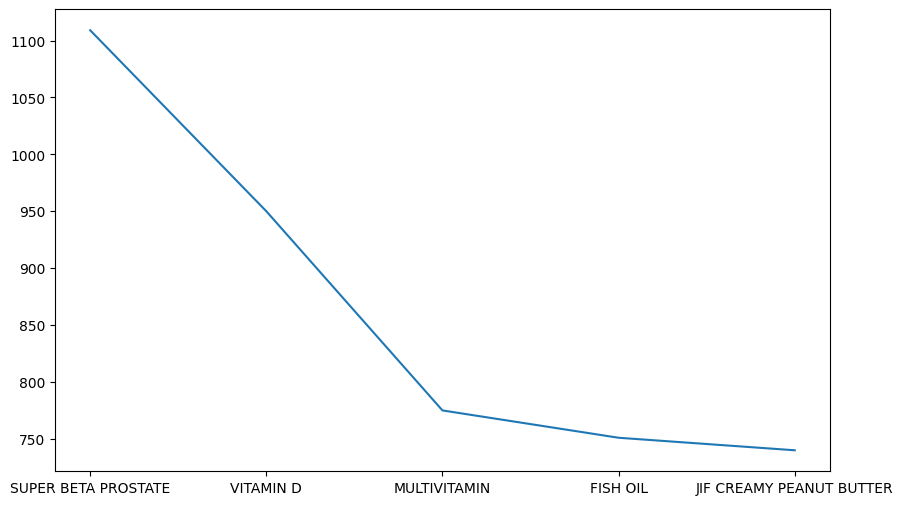

In [ ]:
fatality()

## Cleaning
* Remove Columns that are duplicates or irrelevant
* Remove rows that missing data
* Remove duplicate rows



In [ ]:
fda = fda.drop(columns = ['Unnamed: 12', 'PRODUCT_CODE'])
fda = fda.dropna()
fda = fda.drop_duplicates()
fda.isna().sum()
fda['PRODUCT'] = fda['PRODUCT'].str.upper()

## Transforming Data

Converting ages  to consistent units

In [ ]:
#def transformation():
def ageconvert():
  for idx in range(0,len(fda['AGE_UNITS'])):
    if fda['AGE_UNITS'].iloc[idx] != 'year(s)':
      if fda['AGE_UNITS'].iloc[idx] == 'month(s)':
        #converts the age in months to years
        fda['PATIENT_AGE'].iloc[idx] = fda['PATIENT_AGE'].iloc[idx]//12

      elif fda['AGE_UNITS'].iloc[idx] == 'decade(s)':
        fda['PATIENT_AGE'].iloc[idx] = fda['PATIENT_AGE'].iloc[idx]*10

      #if the patient's age is in weeks or days, they are 0 years old
      else:
        fda['PATIENT_AGE'].iloc[idx] = 0
  fda.drop(columns = ['AGE_UNITS'])

def encode_outcome(): # Sort each case based on case outcomes
  # stores all the possible medical outcomes
  outcomes = []
  for case_outcome in fda['CASE_OUTCOME'].values:
    #gets the individual outcomes if multiple are listed  in the case outcome
    for individual_outcome in case_outcome.split(","):
      if individual_outcome.strip() not in outcomes:
        outcomes.append(individual_outcome.strip())
  #creates the new columns for each outcome
  for outcome in outcomes:
    fda[outcome] = [1 if outcome in row else 0 for row in fda['CASE_OUTCOME']]
  fda.drop(columns=['CASE_OUTCOME'])

def age_ranges():
  # For each age range find the most common outcome and the product category that caused the outcome
  ranges = [-1,3,12,17,29,59,100]
  labels = ['Infant','Child', 'Teenage', 'Young Adult', 'Middle Aged', 'Senior']

  #creates the age range  columns
  fda['AGE_RANGES'] = pd.cut(fda['PATIENT_AGE'], ranges, labels=labels)

In [ ]:
ageconvert()

In [ ]:
encode_outcome()

In [ ]:
age_ranges()

# For each description, count the number of deaths for each description


In [ ]:
# plots a bar chart of number of cases for each age range and sex within the age range
#fda.groupby(['AGE_RANGES','SEX']).count().plot(kind='bar')

# Counting the number of deaths for each description
datawithdeath = fda['CASE_OUTCOME'].str.contains('Death', na=False)
deaths_df = fda[datawithdeath]
deaths_per_description = deaths_df['DESCRIPTION'].value_counts()
deaths_per_description

Cosmetics                                       9717
Vit/Min/Prot/Unconv Diet(Human/Animal)           768
Fishery/Seafood Prod                              83
Dietary Conventional Foods/Meal Replacements      49
Baby Food Products                                32
                                                ... 
Cereal Prep/Breakfast Food                         1
Fruit/Fruit Prod                                   1
Milk/Butter/Dried Milk Prod                        1
Choc/Cocoa Prod                                    1
Soup                                               1
Name: DESCRIPTION, Length: 26, dtype: int64

Top 5 Reported Products and Their Counts:
EXEMPTION 4: 23894
VITAMIN D: 1202
MULTIVITAMIN: 891
VITAMIN C: 719
FISH OIL: 709


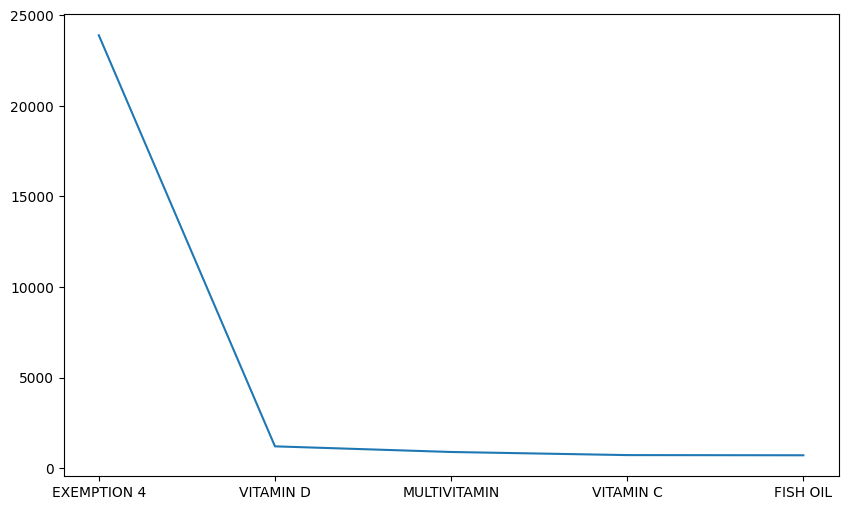

In [ ]:
top_reported_products = fda['PRODUCT'].value_counts().head()
print("Top 5 Reported Products and Their Counts:")
for product, count in top_reported_products.items():
    print(f"{product}: {count}")
plt.plot(top_reported_products)

In [ ]:
# ignore confidential unknown products
fda_noexemption = fda[fda['PRODUCT'] != 'EXEMPTION 4']
# Counting the number of deaths for each description
deaths_df_noexemption = fda_noexemption[fda_noexemption['CASE_OUTCOME'].str.contains('Death', na=False)]
deaths_per_description = deaths_df_noexemption['DESCRIPTION'].value_counts()
deaths_per_description

Vit/Min/Prot/Unconv Diet(Human/Animal)          755
Fishery/Seafood Prod                             83
Cosmetics                                        61
Dietary Conventional Foods/Meal Replacements     45
Baby Food Products                               31
                                               ... 
Cereal Prep/Breakfast Food                        1
Fruit/Fruit Prod                                  1
Milk/Butter/Dried Milk Prod                       1
Choc/Cocoa Prod                                   1
Soup                                              1
Name: DESCRIPTION, Length: 26, dtype: int64

Top 5 Reported Products and Their Counts:
VITAMIN D: 1202
MULTIVITAMIN: 891
VITAMIN C: 719
FISH OIL: 709
CALCIUM: 659


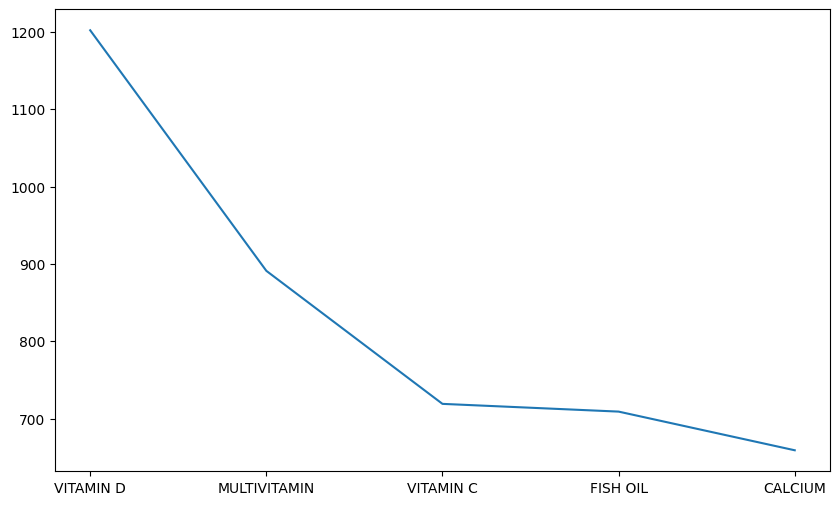

In [ ]:
top_reported_products = fda_noexemption['PRODUCT'].value_counts().head()
print("Top 5 Reported Products and Their Counts:")
for product, count in top_reported_products.items():
    print(f"{product}: {count}")
plt.plot(top_reported_products)

In [ ]:
weights = {
    'Death': 30,
    'Life Threatening': 20,
    'Hospitalization': 18,
    'Disability': 16,
    'Congenital Anomaly': 12,
    'Injury': 10,
    'Required Intervention': 8,
    'Visited Emergency Room': 7,
    'Other Serious or Important Medical Event': 6,
    'Other Serious Outcome': 5,
    'Allergic Reaction': 4,
    'Visited a Health Care Provider': 3,
    'Other Outcome': 2
}
fda['Damage Score'] = fda.apply(lambda row: sum(weights[outcome] for outcome in weights if row.get(f'{outcome}', 0) == 1), axis=1)
pd.set_option('display.max_rows',100)
fda['PRODUCT'] = fda['PRODUCT'].str.lower()
overall_product_damage = fda.groupby('PRODUCT')['Damage Score'].sum()
overall_product_damage_average = fda.groupby('PRODUCT')['Damage Score'].mean()
overall_product_damage_df = pd.merge(
    overall_product_damage.rename('Overall Product Damage Score'),
    overall_product_damage_average.rename('Product Damage Average'),
    left_index=True,
    right_index=True
).reset_index()
overall_product_damage_df['PRODUCT'] = overall_product_damage_df['PRODUCT'].str.upper()
print(overall_product_damage_df.sort_values(by='Overall Product Damage Score', ascending=False).head(10))

            PRODUCT  Overall Product Damage Score  Product Damage Average
10694   EXEMPTION 4                        506181               21.184440
36573     VITAMIN D                         14140               11.763727
21171  MULTIVITAMIN                         11374               12.765432
11148      FISH OIL                          9469               13.355430
36517     VITAMIN C                          8988               12.500695
4539        CALCIUM                          7895               11.980273
17593        KRATOM                          6636               26.758065
36661    VITAMIN D3                          6237               13.470842
19015     MAGNESIUM                          5807               12.408120
29646   RAW OYSTERS                          5512               21.364341


In [ ]:
fdax = fda[fda['PRODUCT'] != 'EXEMPTION 4']
fdax['PRODUCT'] = fdax['PRODUCT'].str.lower()
overall_product_damage = fdax[(fdax['PRODUCT'] != 'EXEMPTION 4') & (fdax['AGE_RANGES'] == 'Senior') & (fdax['SEX'] == 'Female')].groupby(['AGE_RANGES','SEX','PRODUCT'])['Damage Score'].sum().sort_values(ascending=False)
overall_product_damage_average = fdax[fdax['PRODUCT'] != 'EXEMPTION 4'].groupby(['AGE_RANGES','SEX','PRODUCT'])['Damage Score'].mean()
overall_product_damage_df = pd.merge(
    overall_product_damage.rename('Overall Product Damage Score'),
    overall_product_damage_average.rename('Product Damage Average'),
    left_index=True,
    right_index=True
).reset_index()
overall_product_damage_df['PRODUCT'] = overall_product_damage_df['PRODUCT'].str.upper()
print(overall_product_damage_df.sort_values(by='Overall Product Damage Score', ascending=False).head(100))
#overall_product_damage_average = fda.groupby('PRODUCT')['Damage Score'].mean()

   AGE_RANGES     SEX                                            PRODUCT  \
0      Senior  Female                                        EXEMPTION 4   
1      Senior  Female                                          VITAMIN D   
2      Senior  Female                                            CALCIUM   
3      Senior  Female                                           FISH OIL   
4      Senior  Female                                          VITAMIN C   
5      Senior  Female                                       MULTIVITAMIN   
6      Senior  Female                                         VITAMIN D3   
7      Senior  Female                             JOHNSONS POWDER NO UPC   
8      Senior  Female                                          MAGNESIUM   
9      Senior  Female                               PRESERVISION AREDS 2   
10     Senior  Female                                          VITAMIN E   
11     Senior  Female                                             BIOTIN   
12     Senio

In [ ]:
fda.head()

,DATE_FDA_FIRST_RECEIVED_REPORT,REPORT_ID,DATE_EVENT,PRODUCT_TYPE,PRODUCT,DESCRIPTION,PATIENT_AGE,AGE_UNITS,SEX,CASE_MEDDRA_PREFERRED_TERMS,CASE_OUTCOME,Other Serious or Important Medical Event,...,Death,Other Outcome,Disability,Other Serious Outcome,Visited Emergency Room,Allergic Reaction,Visited a Health Care Provider,Required Intervention,Congenital Anomaly,Injury,AGE_RANGES,Damage Score
0,6/30/2023,2023-CFS-006722,6/27/2023,SUSPECT,airline food served by united airlines,Mult Food Dinner/Grav/Sauce/Special,45.0,year(s),Male,"Diarrhoea, Food poisoning, Pyrexia, Tremor, Vo...",Other Serious or Important Medical Event,1,...,0,0,0,0,0,0,0,0,0,0,Middle Aged,6
5,6/30/2023,2023-CFS-006712,6/25/2023,SUSPECT,coke zero,Soft Drink/Water,65.0,year(s),Male,"Disorientation, Fatigue, Seizure","Life Threatening, Hospitalization, Other Serio...",1,...,0,0,0,0,0,0,0,0,0,0,Senior,44
6,6/29/2023,2023-CFS-006687,6/20/2023,SUSPECT,huel black edition,Mult Food Dinner/Grav/Sauce/Special,39.0,year(s),Male,Food poisoning,Other Serious or Important Medical Event,1,...,0,0,0,0,0,0,0,0,0,0,Middle Aged,6
7,6/29/2023,2023-CFS-006682,6/27/2023,SUSPECT,ginkgo biloba,Vit/Min/Prot/Unconv Diet(Human/Animal),92.0,year(s),Female,"Cardiac failure, Death, Hypoglycaemia, Renal f...","Death, Hospitalization",0,...,1,0,0,0,0,0,0,0,0,0,Senior,48
10,6/29/2023,2023-CFS-006676,6/27/2023,SUSPECT,watermelon,Fruit/Fruit Prod,73.0,year(s),Female,"Diarrhoea, Vomiting",Other Serious or Important Medical Event,1,...,0,0,0,0,0,0,0,0,0,0,Senior,6


We can see that the most frequent age range is 50 to 70 years. Furthermore, for each age range we can see that females are more likely to submit reports than males. This could be related to females being more likely to report symptoms of ill health than men

Find the number of cases for each description. Find the brand that was responsible for the most number of cases

In [ ]:

#gets the  demographics under consideration
demographic_data = fda.groupby(['AGE_RANGES','SEX'])['DESCRIPTION'].count()
demographic_data.keys()
demo_data = []
for key in demographic_data.keys():
  if (key[1] != 'Not Reported') and (key[1] != 'Unknown'):
    demo_data.append(key)

demo_data

[('Infant', 'Female'),
 ('Infant', 'Male'),
 ('Child', 'Female'),
 ('Child', 'Male'),
 ('Teenage', 'Female'),
 ('Teenage', 'Male'),
 ('Young Adult', 'Female'),
 ('Young Adult', 'Male'),
 ('Middle Aged', 'Female'),
 ('Middle Aged', 'Male'),
 ('Senior', 'Female'),
 ('Senior', 'Male')]

In [ ]:

pd.set_option('display.max_rows',100)
#dictionary  of lists

demographics_to_products = {}
for demo in demo_data:
  fdax = fda[fda['PRODUCT'] != 'EXEMPTION 4']
  fdax['PRODUCT'] = fdax['PRODUCT'].str.lower()
  overall_product_damage = fdax[(fdax['PRODUCT'] != 'EXEMPTION 4') & (fdax['AGE_RANGES'] == demo[0]) & (fdax['SEX'] == demo[1])].groupby(['AGE_RANGES','SEX','PRODUCT'])['Damage Score'].sum().sort_values(ascending=False)
  overall_product_damage_average = fdax[fdax['PRODUCT'] != 'EXEMPTION 4'].groupby(['AGE_RANGES','SEX','PRODUCT'])['Damage Score'].mean()
  overall_product_damage_df = pd.merge(
      overall_product_damage.rename('Overall Product Damage Score'),
      overall_product_damage_average.rename('Product Damage Average'),
      left_index=True,
      right_index=True
  ).reset_index()
  overall_product_damage_df['PRODUCT'] = overall_product_damage_df['PRODUCT'].str.upper()
  print(overall_product_damage_df.sort_values(by='Overall Product Damage Score', ascending=False).head())

  AGE_RANGES     SEX                     PRODUCT  \
0     Infant  Female                 EXEMPTION 4   
1     Infant  Female                SIMPLY THICK   
2     Infant  Female    ABBOTT SIMILAC ALIMENTUM   
3     Infant  Female              ABBOTT ELECARE   
4     Infant  Female  ABBOTT SIMILAC PRO ADVANCE   

   Overall Product Damage Score  Product Damage Average  
0                           677               19.342857  
1                           360               30.000000  
2                           256               23.272727  
3                           131               21.833333  
4                           127               25.400000  
  AGE_RANGES   SEX                     PRODUCT  Overall Product Damage Score  \
0     Infant  Male                 EXEMPTION 4                          1118   
1     Infant  Male                SIMPLY THICK                           500   
2     Infant  Male    ABBOTT SIMILAC ALIMENTUM                           222   
3     Infant  Male 

In [ ]:
(2,fda[(fda['SEX'] == 'Female') & (fda['AGE_RANGES']  == 'Infant')&(fda['DESCRIPTION'] =='Baby Food Products')].groupby(['AGE_RANGES','SEX','DESCRIPTION','CASE_OUTCOME'])['CASE_OUTCOME'].count().idxmax()[3])

(2, 'Other Outcome')

{('exemption 4', 241627), ('exemption 4', 677), ('exemption 4', 10808), ('exemption 4', 281), ('exemption 4', 235479), ('exemption 4', 849)}
{('exemption 4', 167), ('exemption 4', 1118), ('exemption 4', 3995), ('jif creamy peanut butter', 343), ('exemption 4', 10066), ('kratom', 1848)}


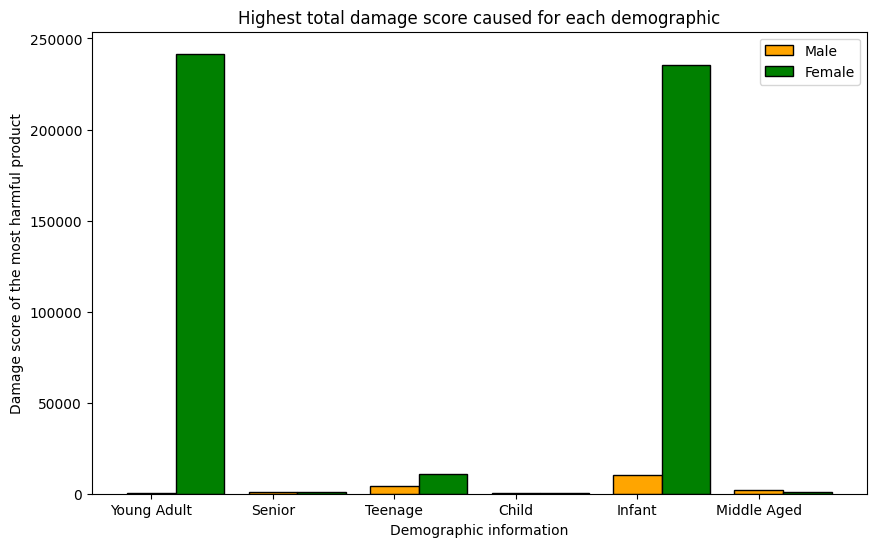

In [ ]:
#generates bar graph: highest damage score vs demographics
age_range = set()
for demographic in demo_data:
  age_range.add(demographic[0])
age_range = list(age_range)

female_data = set()

male_data = set()
#adds the product that caused the highest damagescore and the damagescore itslef
for demographic in demo_data:
  female_data.add((fda[(fda['PRODUCT'] != 'EXEMPTION 4') & (fda['AGE_RANGES'] == demographic[0])& (fda['SEX'] == 'Female')].groupby(['AGE_RANGES','SEX','PRODUCT'])['Damage Score'].sum().sort_values(ascending=False).keys()[0][2],
                   fda[(fda['PRODUCT'] != 'EXEMPTION 4') & (fda['AGE_RANGES'] == demographic[0])& (fda['SEX'] == 'Female')].groupby(['AGE_RANGES','SEX','PRODUCT'])['Damage Score'].sum().sort_values(ascending=False)[0]))
  male_data.add((fda[(fda['PRODUCT'] != 'EXEMPTION 4') & (fda['AGE_RANGES'] == demographic[0])& (fda['SEX'] == 'Male')].groupby(['AGE_RANGES','SEX','PRODUCT'])['Damage Score'].sum().sort_values(ascending=False).keys()[0][2],
                 fda[(fda['PRODUCT'] != 'EXEMPTION 4') & (fda['AGE_RANGES'] == demographic[0])& (fda['SEX'] == 'Male')].groupby(['AGE_RANGES','SEX','PRODUCT'])['Damage Score'].sum().sort_values(ascending=False)[0]))

x = np.arange(6)
female_damage_score = [item[1] for item in female_data]
male_damage_score = [item[1] for item in male_data]


bar_width = 0.4
print(female_data)
print(male_data)
plt.title("Highest total damage score caused for each demographic")
plt.bar(x, male_damage_score, bar_width, color='orange')
plt.bar(x+0.4, female_damage_score, bar_width, color='green')
plt.xticks(x, age_range)
plt.xlabel("Demographic information")
plt.ylabel("Damage score of the most harmful product")
plt.legend(["Male", "Female"])
plt.show()




In [ ]:
d_to_p_new = {}
for demo in demo_data:
  d_to_p_new[demo] = (d_to_p[demo],fda[(fda['SEX'] == demo[1]) & (fda['AGE_RANGES']  == demo[0])&(fda['DESCRIPTION'] == d_to_p[demo])].groupby(['AGE_RANGES','SEX','DESCRIPTION','CASE_OUTCOME'])['CASE_OUTCOME'].count().idxmax()[3])
d_to_p_new

{}

In [ ]:
pd.set_option('display.max_columns',30)


In [ ]:
from pickle import TRUE
fda['DATE_EVENT'] = pd.to_datetime(fda['DATE_EVENT'], infer_datetime_format = TRUE)
fda['DATE_FDA_FIRST_RECEIVED_REPORT'] = pd.to_datetime(fda['DATE_FDA_FIRST_RECEIVED_REPORT'], infer_datetime_format = TRUE)
indexedDataset = fda.set_index('DATE_EVENT')
indexedDataset.head()

##TSA

In [ ]:
for demo in demo_data:
  # Convert DATE_EVENT and DATE_FDA_FIRST_RECEIVED_REPORT to datetime
  fda['DATE_EVENT'] = pd.to_datetime(fda['DATE_EVENT'], errors='coerce')
  fda['DATE_FDA_FIRST_RECEIVED_REPORT'] = pd.to_datetime(fda['DATE_FDA_FIRST_RECEIVED_REPORT'], errors='coerce')

  # Filter out data before 2004 for DATE_EVENT and specify
  fda = fda[(fda['DATE_EVENT'].dt.year >= 2004) & (fda['PRODUCT'] != 'EXEMPTION 4') & (fda['AGE_RANGES'] == demo[0]) & (fda['SEX'] == demo[1])]

  # Setting the aesthetics for the plots
  sns.set(style="whitegrid")

  # Plotting the frequency of reports over time with rolling statistics
  plt.figure(figsize=(15, 6))

  # Rolling window size (in months)
  window_size = 12

  # Frequency of DATE_EVENT with Rolling Statistics
  plt.subplot(1, 2, 1)
  monthly_event_counts = fda['DATE_EVENT'].dropna().groupby(fda['DATE_EVENT'].dropna().dt.to_period("M")).count()
  monthly_event_counts.plot(kind='line', label='Original')
  monthly_event_counts.rolling(window=window_size).mean().plot(label='Rolling Mean')
  monthly_event_counts.rolling(window=window_size).std().plot(label='Rolling Std')
  plt.title('Frequency of Events Over Time with Rolling Statistics')
  plt.xlabel('Date')
  plt.ylabel('Number of Events')
  plt.legend()

  # Frequency of DATE_FDA_FIRST_RECEIVED_REPORT with Rolling Statistics
  plt.subplot(1, 2, 2)
  monthly_fda_counts = fda['DATE_FDA_FIRST_RECEIVED_REPORT'].groupby(
      fda['DATE_FDA_FIRST_RECEIVED_REPORT'].dt.to_period("M")).count()
  monthly_fda_counts.plot(kind='line', label='Original')
  monthly_fda_counts.rolling(window=window_size).mean().plot(label='Rolling Mean')
  monthly_fda_counts.rolling(window=window_size).std().plot(label='Rolling Std')
  plt.title('Frequency of Reports Received by FDA Over Time with Rolling Statistics')
  plt.xlabel('Date')
  plt.ylabel('Number of Reports')
  plt.legend()

  plt.tight_layout()
  plt.show()

In [ ]:
# Applying Dickey-Fuller test on the monthly event counts
dickey_fuller_result_event = adfuller(monthly_event_counts.dropna())
# Print the results for DATE_EVENT
print("Dickey-Fuller Test - DATE_EVENT")
print("-" * 50)
print(f"ADF Statistic: {dickey_fuller_result_event[0]}")
print(f"p-value: {dickey_fuller_result_event[1]}")
print("Critical Values:")
for key, value in dickey_fuller_result_event[4].items():
    print(f"   {key}: {value}")

# Applying Dickey-Fuller test on the monthly FDA report counts
dickey_fuller_result_fda = adfuller(monthly_fda_counts.dropna())
# Print the results for DATE_FDA_FIRST_RECEIVED_REPORT
print("\nDickey-Fuller Test - DATE_FDA_FIRST_RECEIVED_REPORT")
print("-" * 50)
print(f"ADF Statistic: {dickey_fuller_result_fda[0]}")
print(f"p-value: {dickey_fuller_result_fda[1]}")
print("Critical Values:")
for key, value in dickey_fuller_result_fda[4].items():
    print(f"   {key}: {value}")

In [ ]:
### Section for transformed data
# Apply log transformation to stabilize variance hopefully
monthly_event_counts_log = np.log(monthly_event_counts.replace(0, np.nan)).dropna()
monthly_fda_counts_log = np.log(monthly_fda_counts.replace(0, np.nan)).dropna()
# Differencing the log stuff to remove some trend
monthly_event_counts_log_diff = monthly_event_counts_log.diff().dropna()
monthly_fda_counts_log_diff = monthly_fda_counts_log.diff().dropna()

# Plot again
plt.figure(figsize=(15, 6))

# Log + differenced data for DATE_EVENT
plt.subplot(1, 2, 1)
monthly_event_counts_log_diff.plot(kind='line', label='Log Transformed and Differenced')
monthly_event_counts_log_diff.rolling(window=window_size).mean().plot(label='Rolling Mean')
monthly_event_counts_log_diff.rolling(window=window_size).std().plot(label='Rolling Std')
plt.title('Log Transformed and Differenced Events Over Time')
plt.xlabel('Date')
plt.ylabel('Log-Differenced Number of Events')
plt.legend()

# Log + differenced data for DATE_FDA_FIRST_RECEIVED_REPORT
plt.subplot(1, 2, 2)
monthly_fda_counts_log_diff.plot(kind='line', label='Log Transformed and Differenced')
monthly_fda_counts_log_diff.rolling(window=window_size).mean().plot(label='Rolling Mean')
monthly_fda_counts_log_diff.rolling(window=window_size).std().plot(label='Rolling Std')
plt.title('Log Transformed and Differenced FDA Reports Over Time')
plt.xlabel('Date')
plt.ylabel('Log-Differenced Number of Reports')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Applying Dickey-Fuller test on the differenced log-transformed data
dickey_fuller_result_event_diff = adfuller(monthly_event_counts_log_diff)
# Print the results for the differenced log-transformed DATE_EVENT
print("Dickey-Fuller Test - Differenced Log-Transformed DATE_EVENT")
print("-" * 50)
print(f"ADF Statistic: {dickey_fuller_result_event_diff[0]}")
print(f"p-value: {dickey_fuller_result_event_diff[1]}")
print("Critical Values:")
for key, value in dickey_fuller_result_event_diff[4].items():
    print(f"   {key}: {value}")

# Applying Dickey-Fuller test on the differenced log-transformed data
dickey_fuller_result_fda_diff = adfuller(monthly_fda_counts_log_diff)
# Print the results for the differenced log-transformed DATE_FDA_FIRST_RECEIVED_REPORT
print("\nDickey-Fuller Test - Differenced Log-Transformed DATE_FDA_FIRST_RECEIVED_REPORT")
print("-" * 50)
print(f"ADF Statistic: {dickey_fuller_result_fda_diff[0]}")
print(f"p-value: {dickey_fuller_result_fda_diff[1]}")
print("Critical Values:")
for key, value in dickey_fuller_result_fda_diff[4].items():
    print(f"   {key}: {value}")

#Checking

In [ ]:
fda.columns
#isna().sum()